# BAB Dataset: Enhanced Neural ODE & CT-ESN Models

**Multi-dataset training** on multisine + swept sine signals, with **holdout testing** on random steps.  
Includes ablation study over prediction horizon ($K$) and batch size ($B$).

## 0) Imports and Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import bab_datasets as nod

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 1) Load Training & Test Data

**Training data** — multi-dataset: `multisine_05`, `multisine_06`, `swept_sine`  
**Test data** (holdout) — unseen excitation type: `random_steps_01`, `random_steps_02`

  Train:    multisine_05  |  N= 1101  |  Ts=0.05000s  |  T=55.0s
  Train:    multisine_06  |  N= 1101  |  Ts=0.05000s  |  T=55.0s
  Train:      swept_sine  |  N= 1100  |  Ts=0.05000s  |  T=54.9s
  Test:  random_steps_01  |  N= 1101  |  Ts=0.05000s  |  T=55.0s
  Test:  random_steps_02  |  N= 1101  |  Ts=0.05000s  |  T=55.0s


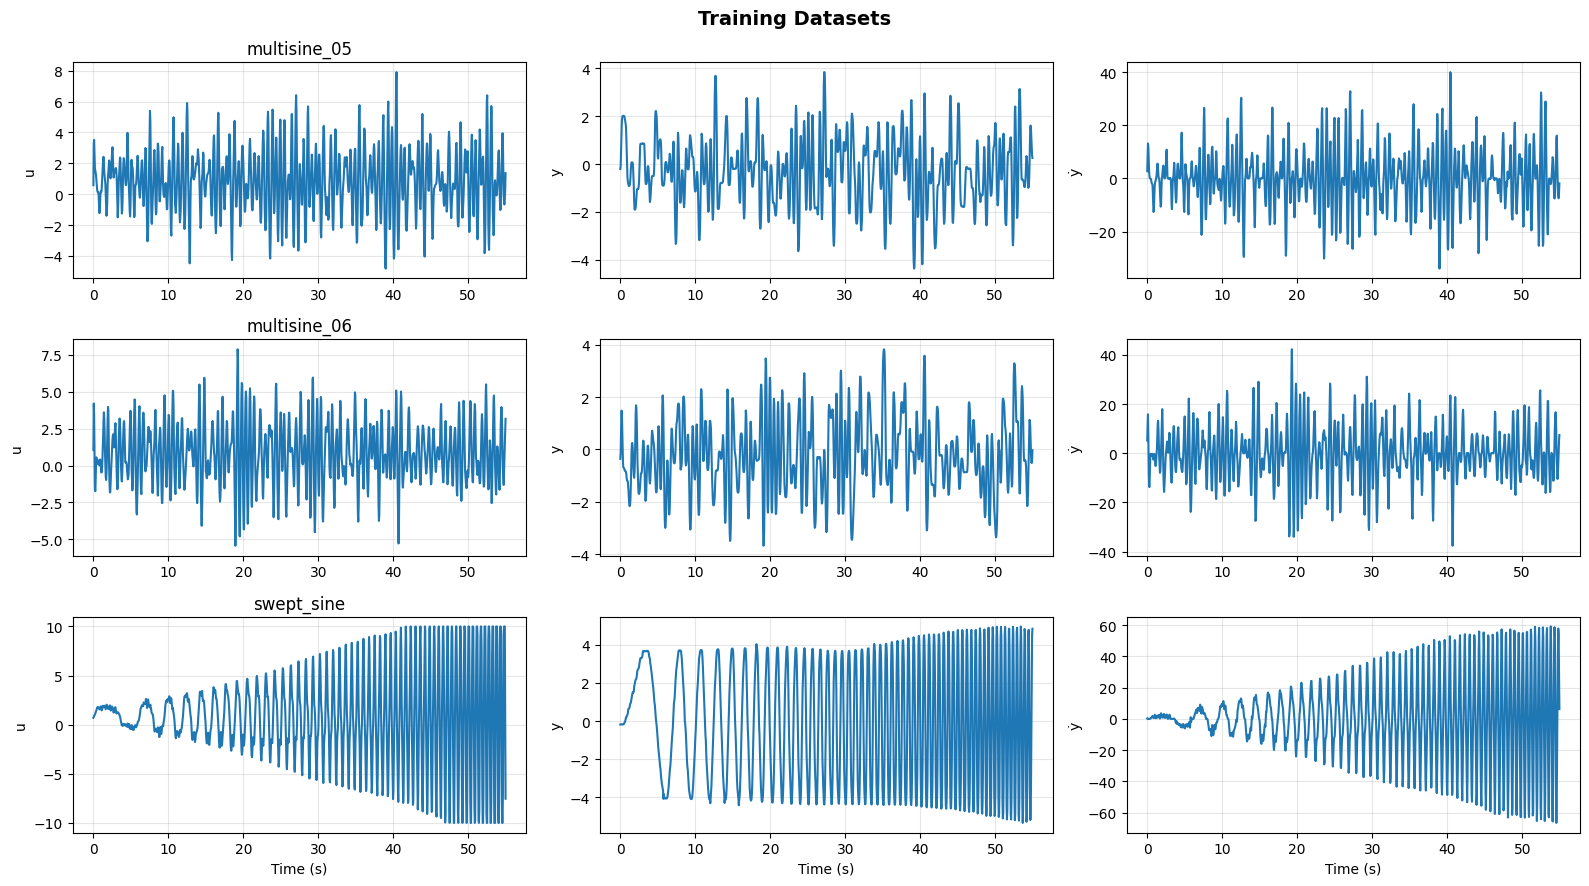

In [2]:
velMethod = "central"
RESAMPLE = 50

# ---------- Training datasets ----------
train_names = ["multisine_05", "multisine_06", "swept_sine"]
train_datasets = []

for ds_name in train_names:
    d = nod.load_experiment(
        ds_name, preprocess=True, plot=False,
        resample_factor=RESAMPLE, y_dot_method=velMethod,
    )
    u_d, y_d, _, ydot_d = d
    Ts_d = d.sampling_time
    t_d = np.arange(len(u_d)) * Ts_d
    train_datasets.append({
        "name": ds_name, "u": u_d, "y": y_d, "y_dot": ydot_d,
        "t": t_d, "Ts": Ts_d,
        "y_sim": np.column_stack([y_d, ydot_d]),
    })
    print(f"  Train: {ds_name:>15s}  |  N={len(u_d):5d}  |  Ts={Ts_d:.5f}s  |  T={t_d[-1]:.1f}s")

# ---------- Holdout test datasets ----------
test_names = ["random_steps_01", "random_steps_02"]
test_datasets = []

for ds_name in test_names:
    d = nod.load_experiment(
        ds_name, preprocess=True, plot=False,
        resample_factor=RESAMPLE, y_dot_method=velMethod,
    )
    u_d, y_d, _, ydot_d = d
    Ts_d = d.sampling_time
    t_d = np.arange(len(u_d)) * Ts_d
    test_datasets.append({
        "name": ds_name, "u": u_d, "y": y_d, "y_dot": ydot_d,
        "t": t_d, "Ts": Ts_d,
        "y_sim": np.column_stack([y_d, ydot_d]),
    })
    print(f"  Test:  {ds_name:>15s}  |  N={len(u_d):5d}  |  Ts={Ts_d:.5f}s  |  T={t_d[-1]:.1f}s")

# Keep the first training set as primary reference (for backward compat)
u, y, y_dot = train_datasets[0]["u"], train_datasets[0]["y"], train_datasets[0]["y_dot"]
t, Ts = train_datasets[0]["t"], train_datasets[0]["Ts"]
y_sim = train_datasets[0]["y_sim"]

# Quick overview
fig, axes = plt.subplots(len(train_datasets), 3, figsize=(16, 3*len(train_datasets)),
                          sharex=False, squeeze=False)
for i, ds in enumerate(train_datasets):
    axes[i, 0].plot(ds["t"], ds["u"]); axes[i, 0].set_ylabel("u")
    axes[i, 0].set_title(ds["name"])
    axes[i, 1].plot(ds["t"], ds["y"]); axes[i, 1].set_ylabel("y")
    axes[i, 2].plot(ds["t"], ds["y_dot"]); axes[i, 2].set_ylabel("ẏ")
    for ax in axes[i]:
        ax.grid(True, alpha=0.3)
for ax in axes[-1]:
    ax.set_xlabel("Time (s)")
fig.suptitle("Training Datasets", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

## 2) Tensor Prep (multi-dataset)

Each training dataset is stored as its own set of tensors so the training loop can randomly sample across datasets.

In [3]:
# --- Per-dataset tensors for multi-dataset training ---
train_tensors = []
for ds in train_datasets:
    tt = torch.tensor(ds["t"], dtype=torch.float32).to(device)
    ut = torch.tensor(ds["u"], dtype=torch.float32).reshape(-1, 1).to(device)
    yt = torch.tensor(ds["y_sim"], dtype=torch.float32).to(device)
    train_tensors.append({"t": tt, "u": ut, "y": yt, "name": ds["name"]})

# --- Test tensors ---
test_tensors = []
for ds in test_datasets:
    tt = torch.tensor(ds["t"], dtype=torch.float32).to(device)
    ut = torch.tensor(ds["u"], dtype=torch.float32).reshape(-1, 1).to(device)
    yt = torch.tensor(ds["y_sim"], dtype=torch.float32).to(device)
    test_tensors.append({"t": tt, "u": ut, "y": yt, "name": ds["name"]})

# Primary tensors (backward compat for model.u_series / .t_series during simulation)
t_tensor = train_tensors[0]["t"]
u_tensor = train_tensors[0]["u"]
y_tensor = train_tensors[0]["y"]

print(f"Training on {len(train_tensors)} datasets, testing on {len(test_tensors)} holdout datasets")

Training on 3 datasets, testing on 2 holdout datasets


## 3) Model Definitions

### 3a) Vanilla NODE Baseline & Ablation Helper

In [4]:
class VanillaNODE(nn.Module):
    """Vanilla Neural ODE: learns both derivatives (no kinematic prior)."""
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, hidden_dim),
            nn.SELU(),
            nn.AlphaDropout(0.05),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SELU(),
            nn.AlphaDropout(0.05),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.SELU(),
            nn.Linear(hidden_dim // 2, 2)
        )
        self.u_series = None
        self.t_series = None
        self.batch_start_times = None

    def forward(self, t, x):
        if self.batch_start_times is not None:
            t_abs = self.batch_start_times + t
        else:
            t_abs = t * torch.ones_like(x[:, 0:1])

        k_idx = torch.searchsorted(self.t_series, t_abs.reshape(-1), right=True)
        k_idx = torch.clamp(k_idx, 1, len(self.t_series) - 1)
        t1, t2 = self.t_series[k_idx - 1].unsqueeze(1), self.t_series[k_idx].unsqueeze(1)
        u1, u2 = self.u_series[k_idx - 1], self.u_series[k_idx]
        denom = (t2 - t1)
        denom[denom < 1e-6] = 1.0
        alpha = (t_abs - t1) / denom
        u_t = u1 + alpha * (u2 - u1)

        nn_input = torch.cat([x, u_t], dim=1)
        return self.net(nn_input)


class StructuredBBODE(nn.Module):
    """Structured Neural ODE with kinematic constraint (BASELINE - WORKS WELL)."""
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, hidden_dim),
            nn.SELU(),
            nn.AlphaDropout(0.05),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SELU(),
            nn.AlphaDropout(0.05),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.SELU(),
            nn.Linear(hidden_dim // 2, 1)
        )
        self.u_series = None
        self.t_series = None
        self.batch_start_times = None

    def forward(self, t, x):
        if self.batch_start_times is not None:
            t_abs = self.batch_start_times + t
        else:
            t_abs = t * torch.ones_like(x[:, 0:1])

        k_idx = torch.searchsorted(self.t_series, t_abs.reshape(-1), right=True)
        k_idx = torch.clamp(k_idx, 1, len(self.t_series) - 1)
        t1, t2 = self.t_series[k_idx - 1].unsqueeze(1), self.t_series[k_idx].unsqueeze(1)
        u1, u2 = self.u_series[k_idx - 1], self.u_series[k_idx]
        denom = (t2 - t1)
        denom[denom < 1e-6] = 1.0
        alpha = (t_abs - t1) / denom
        u_t = u1 + alpha * (u2 - u1)

        th, thd = x[:, 0:1], x[:, 1:2]
        nn_input = torch.cat([th, thd, u_t], dim=1)
        thdd = self.net(nn_input)
        return torch.cat([thd, thdd], dim=1)

### 3b) Enhanced Models - CT-ESN

**CT-ESN-Kinematic**: Only predicts acceleration, hardcodes x_0' = x_1

In [5]:
class ContinuousTimeESN_Kinematic(nn.Module):
    """
    ENHANCED CT-ESN: Kinematic structure (only predicts acceleration).
    FIX: lower leak_rate, learnable input/reservoir scaling, train all params.
    """
    def __init__(self, state_dim=2, input_dim=1, reservoir_dim=200,
                 spectral_radius=0.9, input_scale=0.5, leak_rate=1.0):
        super().__init__()
        self.state_dim = state_dim
        self.input_dim = input_dim
        self.reservoir_dim = reservoir_dim

        # Learnable leak rate (initialised moderate — prevents stiff ODE)
        self.leak_rate = nn.Parameter(torch.tensor(leak_rate))

        # Fixed reservoir matrix
        W = torch.randn(reservoir_dim, reservoir_dim) * 0.1
        mask = (torch.rand_like(W) < 0.8)
        W[mask] = 0.0
        eigvals = torch.linalg.eigvals(W).abs()
        if eigvals.max() > 0:
            W = W * (spectral_radius / eigvals.max())
        self.register_buffer('W_res', W)

        # Learnable input weights (not frozen)
        self.W_in = nn.Parameter(
            torch.randn(reservoir_dim, state_dim + input_dim) * input_scale
        )

        # Output: acceleration (1D)
        self.W_out = nn.Linear(reservoir_dim + state_dim + input_dim, 1, bias=True)

        self.u_series = None
        self.t_series = None
        self.batch_start_times = None

    def forward(self, t, z):
        x = z[:, :self.state_dim]
        r = z[:, self.state_dim:]

        position, velocity = x[:, 0:1], x[:, 1:2]

        if self.batch_start_times is not None:
            t_abs = self.batch_start_times + t
        else:
            t_abs = t * torch.ones_like(position)

        k_idx = torch.searchsorted(self.t_series, t_abs.reshape(-1), right=True)
        k_idx = torch.clamp(k_idx, 1, len(self.t_series) - 1)
        t1, t2 = self.t_series[k_idx - 1].unsqueeze(1), self.t_series[k_idx].unsqueeze(1)
        u1, u2 = self.u_series[k_idx - 1], self.u_series[k_idx]
        denom = (t2 - t1)
        denom[denom < 1e-6] = 1.0
        alpha = (t_abs - t1) / denom
        u_t = u1 + alpha * (u2 - u1)

        xu = torch.cat([x, u_t], dim=1)
        # Clamp leak_rate to prevent it going negative or too large
        lr = torch.clamp(self.leak_rate, 0.1, 10.0)
        dr = lr * (-r + torch.tanh(r @ self.W_res.T + xu @ self.W_in.T))

        # Readout: use reservoir state + direct state/input skip connection
        readout_input = torch.cat([r, x, u_t], dim=1)
        acceleration = self.W_out(readout_input)

        # KINEMATIC STRUCTURE: hardcode x_0' = x_1
        dx = torch.cat([velocity, acceleration], dim=1)

        return torch.cat([dx, dr], dim=1)

    def init_reservoir(self, batch_size):
        return torch.zeros(batch_size, self.reservoir_dim, device=self.W_res.device)

### 3c) Enhanced Models - NODE

**Structured NODE**: Kinematic constraint with single NN.  
**Adaptive NODE**: Base dynamics + near-zero residual correction.

In [6]:
class StructuredNODE(nn.Module):
    """
    Structured NODE: Kinematic constraint, single NN predicts acceleration.
    """
    def __init__(self, hidden_dim=128):
        super().__init__()

        # Single network (same as Structured-BB)
        self.net = nn.Sequential(
            nn.Linear(3, hidden_dim),
            nn.SELU(),
            nn.AlphaDropout(0.05),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SELU(),
            nn.AlphaDropout(0.05),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.SELU(),
            nn.Linear(hidden_dim // 2, 1)
        )

        self.u_series = None
        self.t_series = None
        self.batch_start_times = None

    def forward(self, t, x):
        if self.batch_start_times is not None:
            t_abs = self.batch_start_times + t
        else:
            t_abs = t * torch.ones_like(x[:, 0:1])

        k_idx = torch.searchsorted(self.t_series, t_abs.reshape(-1), right=True)
        k_idx = torch.clamp(k_idx, 1, len(self.t_series) - 1)
        t1, t2 = self.t_series[k_idx - 1].unsqueeze(1), self.t_series[k_idx].unsqueeze(1)
        u1, u2 = self.u_series[k_idx - 1], self.u_series[k_idx]
        denom = (t2 - t1)
        denom[denom < 1e-6] = 1.0
        alpha = (t_abs - t1) / denom
        u_t = u1 + alpha * (u2 - u1)

        th, thd = x[:, 0:1], x[:, 1:2]
        nn_input = torch.cat([th, thd, u_t], dim=1)
        thdd = self.net(nn_input)

        return torch.cat([thd, thdd], dim=1)


class AdaptiveNODE(nn.Module):
    """
    Adaptive NODE: Base dynamics NN + small residual correction NN.
    Both paths receive [θ, θ̇, u]. Residual initialised near zero.
    """
    def __init__(self, hidden_dim=128):
        super().__init__()

        # Main dynamics network: takes [th, thd, u] — same as Structured-BB
        self.dynamics_net = nn.Sequential(
            nn.Linear(3, hidden_dim),
            nn.SELU(),
            nn.AlphaDropout(0.05),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SELU(),
            nn.AlphaDropout(0.05),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.SELU(),
            nn.Linear(hidden_dim // 2, 1)
        )

        # Adaptive residual: state-dependent correction to acceleration
        self.adaptive_residual = nn.Sequential(
            nn.Linear(3, hidden_dim // 2),
            nn.Tanh(),
            nn.Linear(hidden_dim // 2, 1),
        )
        # Initialise residual path near zero so it doesn't destabilise early training
        with torch.no_grad():
            self.adaptive_residual[-1].weight.mul_(0.01)
            self.adaptive_residual[-1].bias.zero_()

        self.u_series = None
        self.t_series = None
        self.batch_start_times = None

    def forward(self, t, x):
        if self.batch_start_times is not None:
            t_abs = self.batch_start_times + t
        else:
            t_abs = t * torch.ones_like(x[:, 0:1])

        k_idx = torch.searchsorted(self.t_series, t_abs.reshape(-1), right=True)
        k_idx = torch.clamp(k_idx, 1, len(self.t_series) - 1)
        t1, t2 = self.t_series[k_idx - 1].unsqueeze(1), self.t_series[k_idx].unsqueeze(1)
        u1, u2 = self.u_series[k_idx - 1], self.u_series[k_idx]
        denom = (t2 - t1)
        denom[denom < 1e-6] = 1.0
        alpha = (t_abs - t1) / denom
        u_t = u1 + alpha * (u2 - u1)

        th, thd = x[:, 0:1], x[:, 1:2]
        nn_input = torch.cat([th, thd, u_t], dim=1)

        # Base acceleration (same structure as Structured-BB)
        base_accel = self.dynamics_net(nn_input)
        # Small state+input-dependent residual correction
        residual = self.adaptive_residual(nn_input)

        thdd = base_accel + residual
        return torch.cat([thd, thdd], dim=1)

### 3d) Controlled NODE
Disappointing results so far with this model...

In [ ]:
# --- Neural CDE (commented out — not used) ---
# import torchcde
#
#
# class CDEFunc(nn.Module):
#     """GRU-style gated vector field for Neural CDE."""
#     def __init__(self, hidden_dim, input_channels):
#         super().__init__()
#         self.hidden_dim = hidden_dim
#         self.input_channels = input_channels
#         self.gate_net = nn.Sequential(
#             nn.Linear(hidden_dim, 64), nn.Tanh(),
#             nn.Linear(64, hidden_dim * input_channels), nn.Sigmoid(),
#         )
#         self.update_net = nn.Sequential(
#             nn.Linear(hidden_dim, 64), nn.Tanh(),
#             nn.Linear(64, hidden_dim * input_channels), nn.Tanh(),
#         )
#     def forward(self, t, z):
#         gate = self.gate_net(z).view(z.size(0), self.hidden_dim, self.input_channels)
#         update = self.update_net(z).view(z.size(0), self.hidden_dim, self.input_channels)
#         return gate * update
#
#
# class NeuralCDE(nn.Module):
#     """Neural CDE for system identification — direct state prediction."""
#     def __init__(self, hidden_dim=64, input_channels=2):
#         super().__init__()
#         self.hidden_dim = hidden_dim
#         self.input_channels = input_channels
#         self.initial_net = nn.Sequential(nn.Linear(2, hidden_dim), nn.Tanh())
#         self.cde_func = CDEFunc(hidden_dim, input_channels)
#         self.norm = nn.LayerNorm(hidden_dim)
#         self.readout = nn.Linear(hidden_dim, 2)
#     def forward(self, X_interp, t_span, x0):
#         z0 = self.initial_net(x0)
#         z_trajectory = torchcde.cdeint(
#             X=X_interp, z0=z0, func=self.cde_func, t=t_span,
#             method='rk4',
#             options={'step_size': (t_span[1] - t_span[0]).item()},
#         )
#         z_trajectory = z_trajectory.permute(1, 0, 2)
#         z_normed = self.norm(z_trajectory)
#         delta = self.readout(z_normed)
#         pred = x0.unsqueeze(0) + delta
#         return pred

## 4) Training Functions (multi-dataset)

Each epoch randomly selects a dataset, then samples a batch of initial conditions from it.
This encourages the model to learn dynamics that generalise across different excitation signals.

In [ ]:
def train_model_multi(model, name, epochs=500, lr=0.02, obs_dim=2,
                      k_steps=20, batch_size=128, log_every=100):
    """
    Multi-dataset training for Neural ODE models.
    Each epoch randomly picks a dataset, then samples a batch of windows.
    """
    print(f"--- Training {name}  (K={k_steps}, B={batch_size}) ---")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs + 1):
        # Pick a random training dataset
        ds = train_tensors[np.random.randint(len(train_tensors))]
        t_ds, u_ds, y_ds = ds["t"], ds["u"], ds["y"]
        dt_local = (t_ds[1] - t_ds[0]).item()
        t_eval = torch.arange(0, k_steps * dt_local, dt_local, device=device)

        model.u_series = u_ds
        model.t_series = t_ds

        optimizer.zero_grad()
        start_idx = np.random.randint(0, len(t_ds) - k_steps, size=batch_size)
        x0 = y_ds[start_idx]
        model.batch_start_times = t_ds[start_idx].reshape(-1, 1)

        pred_state = odeint(model, x0, t_eval, method='rk4')
        pred_obs = pred_state[..., :obs_dim]

        batch_targets = torch.stack([y_ds[i:i + k_steps] for i in start_idx], dim=1)
        loss = torch.mean((pred_obs - batch_targets) ** 2)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
        optimizer.step()

        if epoch % log_every == 0:
            print(f"  Epoch {epoch:>5d} | Loss: {loss.item():.6f}  ({ds['name']})")

    return model


def train_ctesn_multi(model, name, epochs=2000, lr=0.01,
                      k_steps=20, batch_size=128, log_every=100):
    """Multi-dataset training for kinematic CT-ESN.
    FIX: train ALL learnable parameters (W_in, leak_rate, W_out), not just W_out.
    """
    print(f"--- Training {name}  (K={k_steps}, B={batch_size}) ---")
    model.to(device)
    # FIX: train all parameters, not just W_out
    optimizer = optim.Adam(model.parameters(), lr=lr)
    state_dim = model.state_dim

    for epoch in range(epochs + 1):
        ds = train_tensors[np.random.randint(len(train_tensors))]
        t_ds, u_ds, y_ds = ds["t"], ds["u"], ds["y"]
        dt_local = (t_ds[1] - t_ds[0]).item()
        t_eval = torch.arange(0, k_steps * dt_local, dt_local, device=device)

        model.u_series = u_ds
        model.t_series = t_ds

        optimizer.zero_grad()
        start_idx = np.random.randint(0, len(t_ds) - k_steps, size=batch_size)

        x0 = y_ds[start_idx, :state_dim]
        r0 = model.init_reservoir(batch_size)
        z0 = torch.cat([x0, r0], dim=1)
        model.batch_start_times = t_ds[start_idx].reshape(-1, 1)

        pred_z = odeint(model, z0, t_eval, method='rk4')
        pred_obs = pred_z[..., :state_dim]

        batch_targets = torch.stack(
            [y_ds[i:i + k_steps, :state_dim] for i in start_idx], dim=1)
        loss = torch.mean((pred_obs - batch_targets) ** 2)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
        optimizer.step()

        if epoch % log_every == 0:
            print(f"  Epoch {epoch:>5d} | Loss: {loss.item():.6f}  ({ds['name']})")

    return model


def simulate_model(model, ds_tensors, is_esn=False, esn_model=None):
    """
    Full-trajectory simulation on a given dataset.
    Returns (t_np, y_sim_np, pred_np).
    """
    t_ds, u_ds, y_ds = ds_tensors["t"], ds_tensors["u"], ds_tensors["y"]
    model.eval()
    model.u_series = u_ds
    model.t_series = t_ds

    with torch.no_grad():
        model.batch_start_times = torch.zeros(1, 1).to(device)
        if is_esn:
            x0 = y_ds[0, :esn_model.state_dim].unsqueeze(0)
            r0 = esn_model.init_reservoir(1)
            z0 = torch.cat([x0, r0], dim=1)
            pred = odeint(model, z0, t_ds, method='rk4').squeeze(1).cpu().numpy()
            pred = pred[:, :esn_model.state_dim]
        else:
            x0 = y_ds[0].unsqueeze(0)
            pred = odeint(model, x0, t_ds, method='rk4').squeeze(1).cpu().numpy()

    return t_ds.cpu().numpy(), y_ds.cpu().numpy(), pred


# --- Neural CDE training & simulation (commented out — not used) ---
# def train_cde_multi(model, name, epochs=500, lr=0.005,
#                     k_steps=20, batch_size=128, log_every=100):
#     ...
#
# def simulate_cde(model, ds_tensors):
#     ...


def compute_metrics(y_true, y_pred):
    """Compute RMSE, R², FIT% for position and velocity."""
    res_pos = y_true[:, 0] - y_pred[:, 0]
    res_vel = y_true[:, 1] - y_pred[:, 1]
    rmse_pos = np.sqrt(np.mean(res_pos**2))
    rmse_vel = np.sqrt(np.mean(res_vel**2))
    ss_res_pos = np.sum(res_pos**2)
    ss_tot_pos = np.sum((y_true[:, 0] - np.mean(y_true[:, 0]))**2)
    ss_res_vel = np.sum(res_vel**2)
    ss_tot_vel = np.sum((y_true[:, 1] - np.mean(y_true[:, 1]))**2)
    r2_pos = 1 - ss_res_pos / ss_tot_pos if ss_tot_pos > 0 else np.nan
    r2_vel = 1 - ss_res_vel / ss_tot_vel if ss_tot_vel > 0 else np.nan
    fit_pos = 100 * (1 - np.linalg.norm(res_pos) / np.linalg.norm(y_true[:, 0] - np.mean(y_true[:, 0])))
    fit_vel = 100 * (1 - np.linalg.norm(res_vel) / np.linalg.norm(y_true[:, 1] - np.mean(y_true[:, 1])))
    return {
        "rmse_pos": rmse_pos, "rmse_vel": rmse_vel,
        "r2_pos": r2_pos, "r2_vel": r2_vel,
        "fit_pos": fit_pos, "fit_vel": fit_vel,
        "res_pos": res_pos, "res_vel": res_vel,
    }

## 5) Train Baseline Models (multi-dataset)

Trained on all 3 training datasets simultaneously.

In [9]:
vanilla_model = VanillaNODE(hidden_dim=128)
vanilla_model = train_model_multi(vanilla_model, "Vanilla NODE", epochs=5000, lr=0.01)

--- Training Vanilla NODE  (K=20, B=128) ---
  Epoch     0 | Loss: 140.802795  (multisine_06)
  Epoch   100 | Loss: 0.900034  (multisine_06)
  Epoch   200 | Loss: 2.980584  (swept_sine)
  Epoch   300 | Loss: 0.478928  (multisine_05)
  Epoch   400 | Loss: 1.521525  (swept_sine)
  Epoch   500 | Loss: 0.586037  (multisine_06)
  Epoch   600 | Loss: 0.466631  (multisine_05)
  Epoch   700 | Loss: 0.433260  (multisine_06)
  Epoch   800 | Loss: 0.844171  (swept_sine)
  Epoch   900 | Loss: 0.661892  (swept_sine)
  Epoch  1000 | Loss: 0.308848  (multisine_06)
  Epoch  1100 | Loss: 0.233465  (multisine_06)
  Epoch  1200 | Loss: 0.513302  (multisine_05)
  Epoch  1300 | Loss: 0.432088  (multisine_06)
  Epoch  1400 | Loss: 0.378681  (multisine_05)
  Epoch  1500 | Loss: 0.660573  (swept_sine)
  Epoch  1600 | Loss: 0.584380  (multisine_06)
  Epoch  1700 | Loss: 0.486304  (multisine_06)
  Epoch  1800 | Loss: 0.731193  (swept_sine)
  Epoch  1900 | Loss: 0.355147  (multisine_06)
  Epoch  2000 | Loss: 0.8

## 6) Train Enhanced Models (multi-dataset)

In [10]:
esn_kinematic = ContinuousTimeESN_Kinematic(
    state_dim=2, input_dim=1, reservoir_dim=200,
    spectral_radius=0.95, input_scale=0.5, leak_rate=1.0,
)
# Longer horizon (K=40) helps reservoir build up useful hidden state
esn_kinematic = train_ctesn_multi(esn_kinematic, "CT-ESN-Kinematic",
                                  epochs=5000, lr=0.005, k_steps=40)

--- Training CT-ESN-Kinematic  (K=40, B=128) ---
  Epoch     0 | Loss: 184.835022  (multisine_05)
  Epoch   100 | Loss: 418.165955  (swept_sine)
  Epoch   200 | Loss: 63.231071  (multisine_06)
  Epoch   300 | Loss: 50.178150  (multisine_05)
  Epoch   400 | Loss: 237.926025  (swept_sine)
  Epoch   500 | Loss: 196.356934  (swept_sine)
  Epoch   600 | Loss: 15.153064  (multisine_05)
  Epoch   700 | Loss: 122.640198  (swept_sine)
  Epoch   800 | Loss: 11.102136  (multisine_06)
  Epoch   900 | Loss: 8.728465  (multisine_05)
  Epoch  1000 | Loss: 7.802180  (multisine_05)
  Epoch  1100 | Loss: 7.411304  (multisine_05)
  Epoch  1200 | Loss: 6.259988  (multisine_05)
  Epoch  1300 | Loss: 6.716155  (multisine_05)
  Epoch  1400 | Loss: 6.244236  (multisine_06)
  Epoch  1500 | Loss: 6.077171  (multisine_05)
  Epoch  1600 | Loss: 6.175721  (multisine_05)
  Epoch  1700 | Loss: 57.871681  (swept_sine)
  Epoch  1800 | Loss: 4.814099  (multisine_06)
  Epoch  1900 | Loss: 49.006916  (swept_sine)
  Epoch

### 6b) Structured NODE & Adaptive NODE (multi-dataset)

In [11]:
structured_node = StructuredNODE(hidden_dim=128)
structured_node = train_model_multi(structured_node, "Structured NODE", epochs=5000, lr=0.01)

adaptive_node = AdaptiveNODE(hidden_dim=128)
adaptive_node = train_model_multi(adaptive_node, "Adaptive NODE", epochs=5000, lr=0.005)

--- Training Structured NODE  (K=20, B=128) ---
  Epoch     0 | Loss: 661.634888  (swept_sine)
  Epoch   100 | Loss: 1.955890  (swept_sine)
  Epoch   200 | Loss: 0.406321  (multisine_05)
  Epoch   300 | Loss: 1.295990  (swept_sine)
  Epoch   400 | Loss: 0.324596  (multisine_06)
  Epoch   500 | Loss: 0.721136  (swept_sine)
  Epoch   600 | Loss: 0.306045  (multisine_05)
  Epoch   700 | Loss: 0.388911  (multisine_05)
  Epoch   800 | Loss: 0.299473  (multisine_06)
  Epoch   900 | Loss: 0.692236  (swept_sine)
  Epoch  1000 | Loss: 0.706936  (swept_sine)
  Epoch  1100 | Loss: 0.749408  (swept_sine)
  Epoch  1200 | Loss: 0.263884  (multisine_06)
  Epoch  1300 | Loss: 0.240427  (multisine_06)
  Epoch  1400 | Loss: 0.270839  (multisine_06)
  Epoch  1500 | Loss: 0.430456  (swept_sine)
  Epoch  1600 | Loss: 0.226322  (multisine_06)
  Epoch  1700 | Loss: 0.327285  (multisine_05)
  Epoch  1800 | Loss: 0.176224  (multisine_06)
  Epoch  1900 | Loss: 0.400222  (swept_sine)
  Epoch  2000 | Loss: 0.6678

In [ ]:
# --- Neural CDE training (commented out — not used) ---
# cde_model = NeuralCDE(hidden_dim=64, input_channels=2)
# cde_model = train_cde_multi(cde_model, "Neural CDE", epochs=10000, lr=0.001, k_steps=40)

--- Training Neural CDE  (K=40, B=128) ---
  Epoch     0 | Loss: 108.816895  (multisine_06)
  Epoch   100 | Loss: 49.298988  (multisine_05)
  Epoch   200 | Loss: 26.351191  (multisine_05)
  Epoch   300 | Loss: 15.500519  (multisine_05)
  Epoch   400 | Loss: 11.207270  (multisine_06)
  Epoch   500 | Loss: 7.303060  (multisine_06)
  Epoch   600 | Loss: 7.668605  (multisine_06)
  Epoch   700 | Loss: 5.799545  (multisine_05)
  Epoch   800 | Loss: 5.551744  (multisine_06)
  Epoch   900 | Loss: 84.258812  (swept_sine)
  Epoch  1000 | Loss: 77.998535  (swept_sine)
  Epoch  1100 | Loss: 5.122452  (multisine_05)
  Epoch  1200 | Loss: 4.543813  (multisine_06)
  Epoch  1300 | Loss: 4.326663  (multisine_05)
  Epoch  1400 | Loss: 4.473333  (multisine_06)
  Epoch  1500 | Loss: 86.931046  (swept_sine)
  Epoch  1600 | Loss: 66.571510  (swept_sine)
  Epoch  1700 | Loss: 3.087572  (multisine_06)
  Epoch  1800 | Loss: 72.324547  (swept_sine)
  Epoch  1900 | Loss: 4.289988  (multisine_06)
  Epoch  2000 | 

## 7) Simulate & Evaluate — Training Data + Holdout Test Data

Models are simulated on:
- **Training data** (multisine_05) — to check fitting quality
- **Holdout test data** (random_steps_01, random_steps_02) — to check generalisation

In [41]:
# ---------- Model registry ----------
# type: "ode" (standard NODE), "esn" (CT-ESN)
model_registry = {
    "Vanilla NODE":     (vanilla_model,    "ode"),
    "CT-ESN-Kin.":      (esn_kinematic,    "esn"),
    "Structured NODE":  (structured_node,  "ode"),
    "Adaptive NODE":    (adaptive_node,    "ode"),
    # "Neural CDE":       (cde_model,        "cde"),  # commented out
}

# ---------- Evaluate on ALL datasets (train + test) ----------
eval_datasets = (
    [("train", ds) for ds in train_tensors] +
    [("test",  ds) for ds in test_tensors]
)

results = {}   # results[model_name][split][dataset_name] = metrics dict

for model_name, (model, mtype) in model_registry.items():
    results[model_name] = {"train": {}, "test": {}}
    for split, ds in eval_datasets:
        t_np, y_true, y_pred = simulate_model(
            model, ds, is_esn=(mtype == "esn"),
            esn_model=esn_kinematic if mtype == "esn" else None,
        )
        m = compute_metrics(y_true, y_pred)
        m["t"] = t_np; m["y_true"] = y_true; m["y_pred"] = y_pred
        results[model_name][split][ds["name"]] = m

print("Simulation & evaluation complete!")

# ---------- Summary Table ----------
def print_metrics_table(results, split, metric_key="fit_pos", fmt=".1f"):
    ds_names = list(next(iter(results.values()))[split].keys())
    header = f"{'Model':<20}" + "".join(f"{n:>16}" for n in ds_names) + f"{'Mean':>10}"
    print(header)
    print("-" * len(header))
    for model_name in results:
        vals = [results[model_name][split][dn][metric_key] for dn in ds_names]
        row = f"{model_name:<20}" + "".join(f"{v:>16{fmt}}" for v in vals)
        row += f"{np.mean(vals):>10{fmt}}"
        print(row)

print("\n" + "="*80)
print("TRAINING DATA — FIT% (Position)")
print("="*80)
print_metrics_table(results, "train", "fit_pos")

print("\n" + "="*80)
print("TRAINING DATA — R² (Position)")
print("="*80)
print_metrics_table(results, "train", "r2_pos", fmt=".4f")

print("\n" + "="*80)
print("TRAINING DATA — R² (Velocity)")
print("="*80)
print_metrics_table(results, "train", "r2_vel", fmt=".4f")

print("\n" + "="*80)
print("HOLDOUT TEST DATA — FIT% (Position)")
print("="*80)
print_metrics_table(results, "test", "fit_pos")

print("\n" + "="*80)
print("HOLDOUT TEST DATA — FIT% (Velocity)")
print("="*80)
print_metrics_table(results, "test", "fit_vel")

print("\n" + "="*80)
print("HOLDOUT TEST DATA — R² (Position)")
print("="*80)
print_metrics_table(results, "test", "r2_pos", fmt=".4f")

print("\n" + "="*80)
print("HOLDOUT TEST DATA — R² (Velocity)")
print("="*80)
print_metrics_table(results, "test", "r2_vel", fmt=".4f")

Simulation & evaluation complete!

TRAINING DATA — FIT% (Position)
Model                   multisine_05    multisine_06      swept_sine      Mean
------------------------------------------------------------------------------
Vanilla NODE                    12.9            16.1            80.4      36.4
CT-ESN-Kin.                     58.6            63.8            74.1      65.5
Structured NODE                 65.9            73.9            89.1      76.3
Adaptive NODE                   61.2            53.4            82.3      65.6

TRAINING DATA — R² (Position)
Model                   multisine_05    multisine_06      swept_sine      Mean
------------------------------------------------------------------------------
Vanilla NODE                  0.2418          0.2955          0.9614    0.4996
CT-ESN-Kin.                   0.8287          0.8688          0.9330    0.8769
Structured NODE               0.8837          0.9317          0.9882    0.9345
Adaptive NODE                 0.8

## 8) Visualisation — Train vs Holdout Test

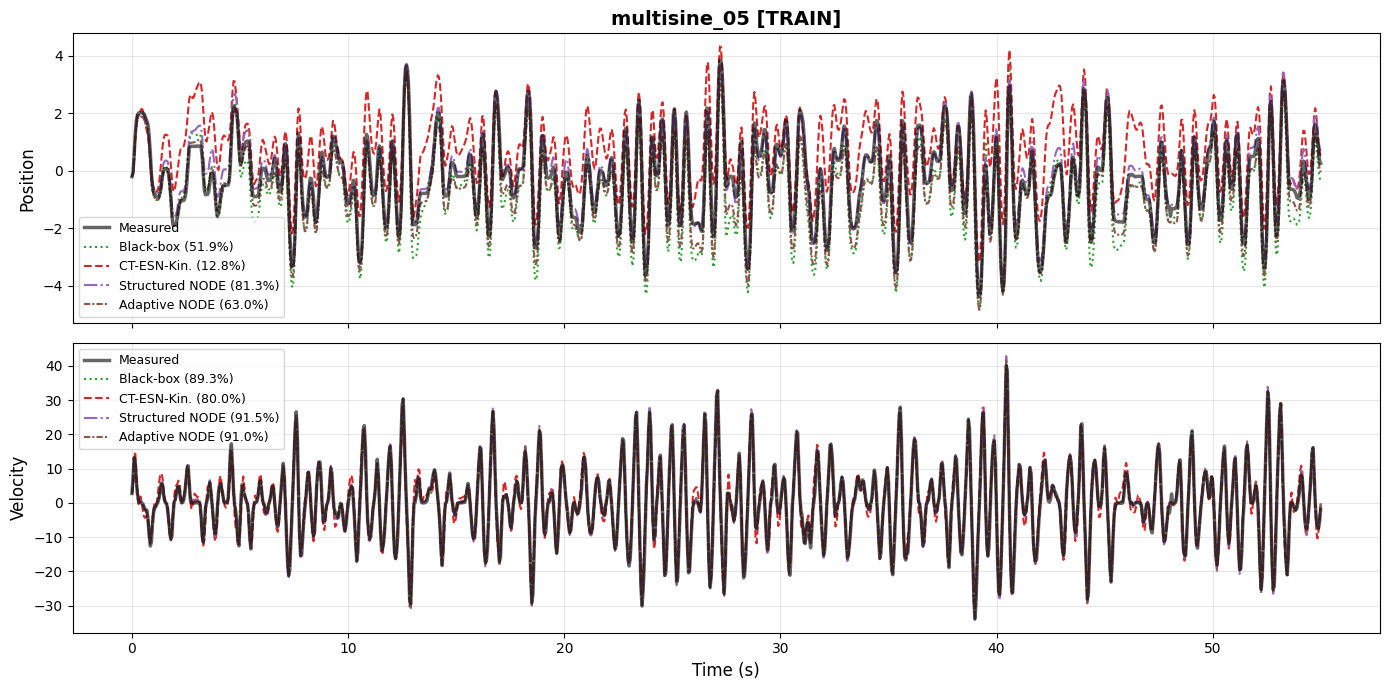

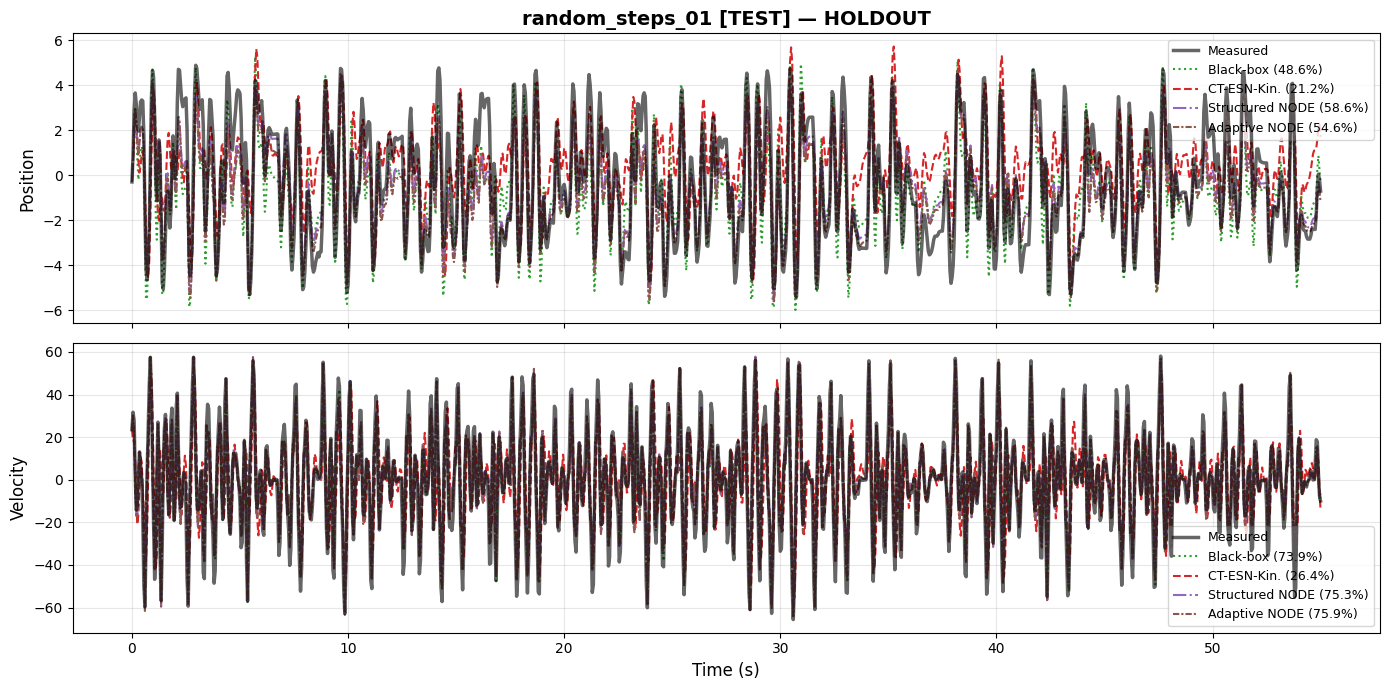

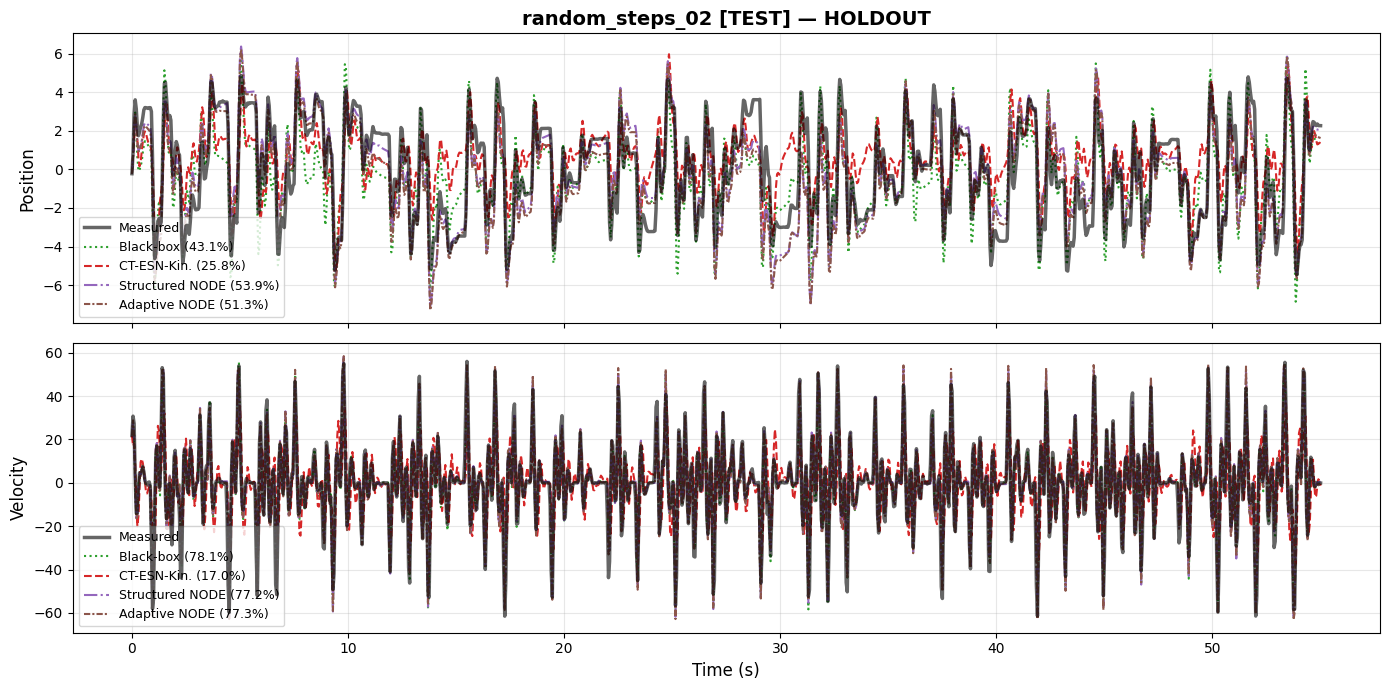

In [ ]:
colors = {
    "Vanilla NODE": "tab:green",
    "CT-ESN-Kin.": "tab:red", "Structured NODE": "tab:purple",
    "Adaptive NODE": "tab:brown",
    # "Neural CDE": "tab:cyan",  # commented out
}
styles = {
    "Vanilla NODE": ":",
    "CT-ESN-Kin.": "--", "Structured NODE": "-.",
    "Adaptive NODE": (0, (3, 1, 1, 1)),
    # "Neural CDE": (0, (5, 1)),  # commented out
}

def plot_comparison(results, split, ds_name, title_suffix=""):
    """Plot position + velocity comparison for one dataset."""
    fig, axes = plt.subplots(2, 1, figsize=(14, 7), sharex=True)
    r0 = next(iter(results.values()))[split][ds_name]
    t_plot = r0["t"]
    y_true = r0["y_true"]

    for ax_idx, (signal, ylabel) in enumerate([(0, "Position"), (1, "Velocity")]):
        ax = axes[ax_idx]
        ax.plot(t_plot, y_true[:, signal], 'k-', alpha=0.6, lw=2.5, label='Measured', zorder=10)
        for model_name in results:
            r = results[model_name][split][ds_name]
            fit_key = "fit_pos" if signal == 0 else "fit_vel"
            ax.plot(t_plot, r["y_pred"][:, signal],
                    linestyle=styles[model_name], color=colors[model_name], lw=1.5,
                    label=f"{model_name} ({r[fit_key]:.1f}%)")
        ax.set_ylabel(ylabel, fontsize=12)
        ax.legend(fontsize=9, loc="best")
        ax.grid(True, alpha=0.3)
    axes[0].set_title(f"{ds_name} [{split.upper()}]{title_suffix}", fontsize=14, fontweight='bold')
    axes[1].set_xlabel("Time (s)", fontsize=12)
    plt.tight_layout(); plt.show()

# --- Plot one representative training dataset ---
plot_comparison(results, "train", train_tensors[0]["name"])

# --- Plot each holdout test dataset ---

for ds in test_tensors:    plot_comparison(results, "test", ds["name"], " — HOLDOUT")

## 9) Train vs Test Summary Bar Chart

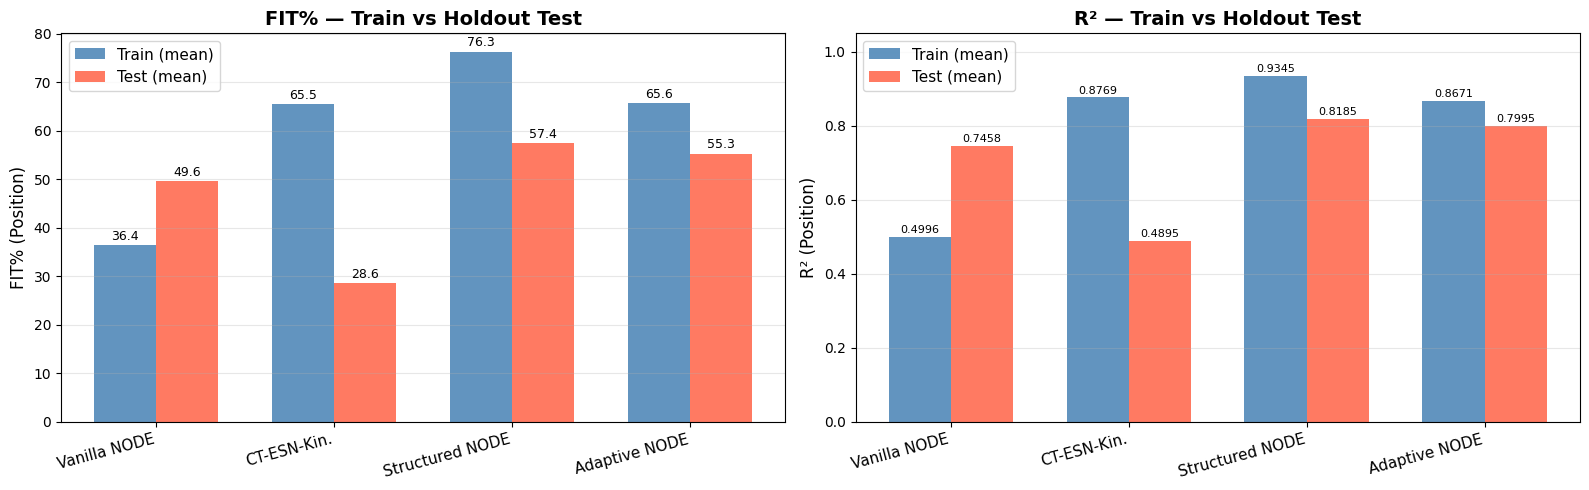

In [43]:
# --- Grouped bar chart: Train vs Test FIT% and R² ---
model_names = list(results.keys())
train_ds_names = [ds["name"] for ds in train_tensors]
test_ds_names = [ds["name"] for ds in test_tensors]

train_fit = [np.mean([results[m]["train"][dn]["fit_pos"] for dn in train_ds_names]) for m in model_names]
test_fit  = [np.mean([results[m]["test"][dn]["fit_pos"]  for dn in test_ds_names])  for m in model_names]
train_r2  = [np.mean([results[m]["train"][dn]["r2_pos"]  for dn in train_ds_names]) for m in model_names]
test_r2   = [np.mean([results[m]["test"][dn]["r2_pos"]   for dn in test_ds_names])  for m in model_names]

x = np.arange(len(model_names))
w = 0.35

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# --- FIT% bar chart ---
bars1 = ax1.bar(x - w/2, train_fit, w, label='Train (mean)', color='steelblue', alpha=0.85)
bars2 = ax1.bar(x + w/2, test_fit,  w, label='Test (mean)',  color='tomato',    alpha=0.85)
ax1.set_ylabel('FIT% (Position)', fontsize=12)
ax1.set_title('FIT% — Train vs Holdout Test', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(model_names, rotation=15, ha='right', fontsize=11)
ax1.legend(fontsize=11)
ax1.grid(axis='y', alpha=0.3)
for bar in bars1:
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{bar.get_height():.1f}', ha='center', va='bottom', fontsize=9)
for bar in bars2:
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{bar.get_height():.1f}', ha='center', va='bottom', fontsize=9)

# --- R² bar chart ---
bars3 = ax2.bar(x - w/2, train_r2, w, label='Train (mean)', color='steelblue', alpha=0.85)
bars4 = ax2.bar(x + w/2, test_r2,  w, label='Test (mean)',  color='tomato',    alpha=0.85)
ax2.set_ylabel('R² (Position)', fontsize=12)
ax2.set_title('R² — Train vs Holdout Test', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(model_names, rotation=15, ha='right', fontsize=11)
ax2.legend(fontsize=11)
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim(None, 1.05)
for bar in bars3:
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{bar.get_height():.4f}', ha='center', va='bottom', fontsize=8)
for bar in bars4:
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{bar.get_height():.4f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

In [ ]:
import time as _time

def ablation_train_and_eval(k_steps, batch_size, epochs=800, lr=0.01,
                            full_sim=False):
    """
    Train a fresh Structured-BB with given K/B, then evaluate on train + test.
    If full_sim=True, use full-trajectory loss (single IC, entire dataset).
    """
    model = StructuredBBODE(hidden_dim=128).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    t0 = _time.time()

    if full_sim:
        # ------- Full-simulation loss (one dataset at a time) -------
        for epoch in range(epochs + 1):
            ds = train_tensors[np.random.randint(len(train_tensors))]
            t_ds, u_ds, y_ds = ds["t"], ds["u"], ds["y"]
            model.u_series, model.t_series = u_ds, t_ds

            optimizer.zero_grad()
            model.batch_start_times = torch.zeros(1, 1).to(device)
            x0 = y_ds[0].unsqueeze(0)
            pred = odeint(model, x0, t_ds, method='rk4')  # (T, 1, 2)
            loss = torch.mean((pred.squeeze(1) - y_ds) ** 2)
            loss.backward()
            optimizer.step()

            if epoch % 200 == 0:
                print(f"  [full-sim] Epoch {epoch:>5d} | Loss: {loss.item():.6f}")
    else:
        # ------- Multiple-shooting loss -------
        for epoch in range(epochs + 1):
            ds = train_tensors[np.random.randint(len(train_tensors))]
            t_ds, u_ds, y_ds = ds["t"], ds["u"], ds["y"]
            dt_local = (t_ds[1] - t_ds[0]).item()
            t_eval = torch.arange(0, k_steps * dt_local, dt_local, device=device)
            model.u_series, model.t_series = u_ds, t_ds

            optimizer.zero_grad()
            start_idx = np.random.randint(0, len(t_ds) - k_steps, size=batch_size)
            x0 = y_ds[start_idx]
            model.batch_start_times = t_ds[start_idx].reshape(-1, 1)

            pred_state = odeint(model, x0, t_eval, method='rk4')
            batch_targets = torch.stack([y_ds[i:i + k_steps] for i in start_idx], dim=1)
            loss = torch.mean((pred_state - batch_targets) ** 2)
            loss.backward()
            optimizer.step()

    wall_time = _time.time() - t0

    # Evaluate on first train dataset + first test dataset
    model.eval()
    train_m = {}
    for ds in train_tensors[:1]:
        _, y_true, y_pred = simulate_model(model, ds)
        train_m[ds["name"]] = compute_metrics(y_true, y_pred)

    test_m = {}
    for ds in test_tensors[:1]:
        _, y_true, y_pred = simulate_model(model, ds)
        test_m[ds["name"]] = compute_metrics(y_true, y_pred)

    train_fit = np.mean([m["fit_pos"] for m in train_m.values()])
    test_fit  = np.mean([m["fit_pos"] for m in test_m.values()])

    return train_fit, test_fit, wall_time

# ---------- Run ablation ----------
K_values = [10, 20, 50, 100]
B_values = [64, 128, 256]
ABLATION_EPOCHS = 800

ablation_results = []

print("="*80)
print("ABLATION: K-steps × Batch-size  (Structured-BB, {} epochs)".format(ABLATION_EPOCHS))
print("="*80)

for K in K_values:
    for B in B_values:
        label = f"K={K:>3d}, B={B:>3d}"
        print(f"\n--- {label} ---")
        tr, te, wt = ablation_train_and_eval(K, B, epochs=ABLATION_EPOCHS)
        ablation_results.append({"K": K, "B": B, "train_fit": tr, "test_fit": te,
                                  "wall_s": wt, "label": label})
        print(f"  → Train FIT={tr:.1f}%  |  Test FIT={te:.1f}%  |  Time={wt:.1f}s")

# ---------- Full-simulation loss ----------
print(f"\n--- Full-simulation loss (K=all) ---")
tr, te, wt = ablation_train_and_eval(None, None, epochs=min(ABLATION_EPOCHS, 400),
                                      full_sim=True)
ablation_results.append({"K": "full", "B": 1, "train_fit": tr, "test_fit": te,
                          "wall_s": wt, "label": "K=full, B=1"})
print(f"  → Train FIT={tr:.1f}%  |  Test FIT={te:.1f}%  |  Time={wt:.1f}s")

ABLATION: K-steps × Batch-size  (Structured-BB, 800 epochs)

--- K= 10, B= 64 ---
  → Train FIT=77.2%  |  Test FIT=29.1%  |  Time=12.2s

--- K= 10, B=128 ---
  → Train FIT=79.9%  |  Test FIT=43.9%  |  Time=17.3s

--- K= 10, B=256 ---
  → Train FIT=81.9%  |  Test FIT=52.1%  |  Time=29.0s

--- K= 20, B= 64 ---
  → Train FIT=80.1%  |  Test FIT=47.2%  |  Time=26.1s

--- K= 20, B=128 ---
  → Train FIT=77.5%  |  Test FIT=29.2%  |  Time=37.2s

--- K= 20, B=256 ---
  → Train FIT=71.6%  |  Test FIT=32.5%  |  Time=60.9s

--- K= 50, B= 64 ---
  → Train FIT=66.8%  |  Test FIT=24.0%  |  Time=64.8s

--- K= 50, B=128 ---


KeyboardInterrupt: 


ABLATION STUDY RESULTS — Structured-BB Neural ODE
Config                 Train FIT%    Test FIT%   Time (s)
--------------------------------------------------------
K= 10, B= 64                80.7%        38.6%      12.3
K= 10, B=128                80.9%        39.7%      17.4
K= 10, B=256                52.7%        61.2%      28.9
K= 20, B= 64                78.3%        45.1%      25.6
K= 20, B=128                80.4%        46.5%      37.0
K= 20, B=256                79.3%        45.9%      61.8
K= 50, B= 64                66.4%        49.1%      70.2
K= 50, B=128                71.8%        40.2%      95.4
K= 50, B=256                44.8%        40.4%     156.1
K=100, B= 64                70.2%        35.0%     135.1
K=100, B=128                72.8%        53.8%     192.7
K=100, B=256                48.2%        48.4%     317.2
K=full, B=1                 -3.6%      -137.6%     386.0
--------------------------------------------------------


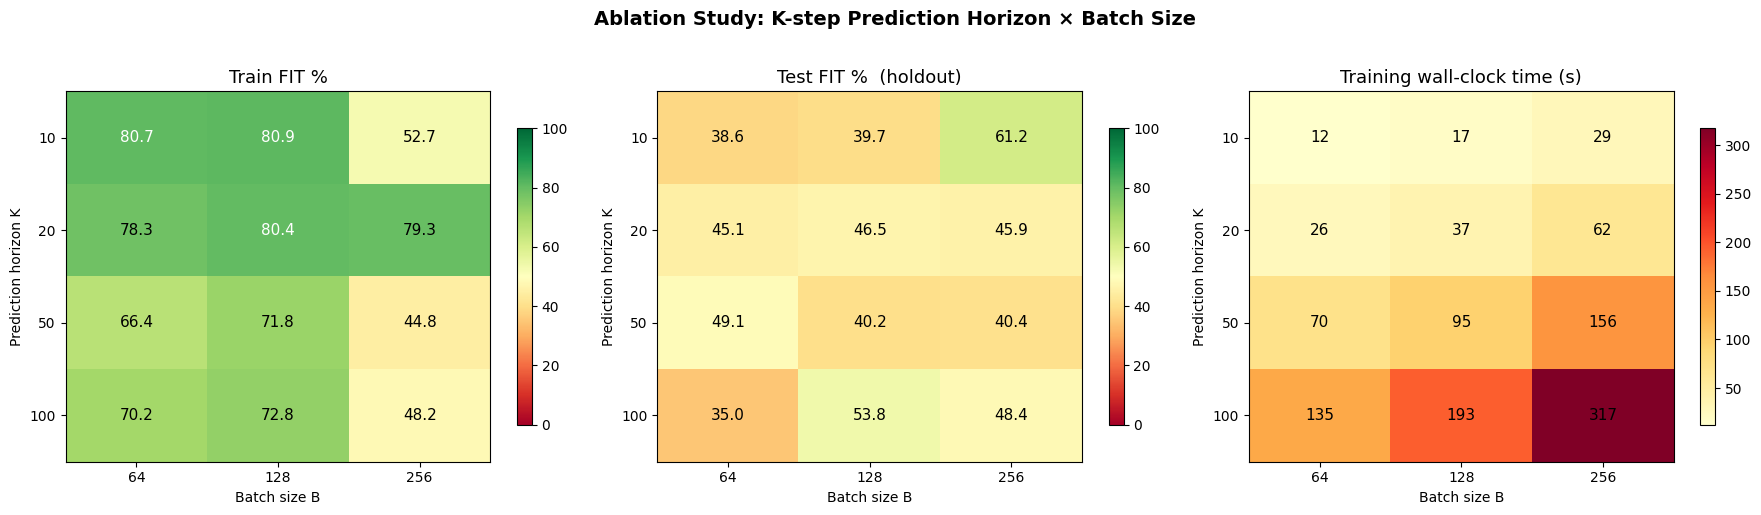


★ Full-simulation baseline:  Train FIT = -3.6%  |  Test FIT = -137.6%  |  Time = 386.0s


In [ ]:
# ── Ablation Results: Table + Heatmap ──

import pandas as pd

df_abl = pd.DataFrame(ablation_results)

# ── Pretty table ──
print("\n" + "="*80)
print("ABLATION STUDY RESULTS — Structured NODE")
print("="*80)
print(f"{'Config':<20s} {'Train FIT%':>12s} {'Test FIT%':>12s} {'Time (s)':>10s}")
print("-"*56)
for _, r in df_abl.iterrows():
    print(f"{r['label']:<20s} {r['train_fit']:>11.1f}% {r['test_fit']:>11.1f}% {r['wall_s']:>9.1f}")
print("-"*56)

# ── Heatmaps: Train FIT% and Test FIT% ──
df_grid = df_abl[df_abl["K"] != "full"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, metric, title in zip(axes[:2],
                              ["train_fit", "test_fit"],
                              ["Train FIT %", "Test FIT %  (holdout)"]):
    pivot = df_grid.pivot(index="K", columns="B", values=metric)
    pivot = pivot.sort_index(ascending=True)
    im = ax.imshow(pivot.values, cmap="RdYlGn", aspect="auto",
                   vmin=0, vmax=100)
    ax.set_xticks(range(len(pivot.columns)))
    ax.set_xticklabels(pivot.columns)
    ax.set_yticks(range(len(pivot.index)))
    ax.set_yticklabels(pivot.index)
    ax.set_xlabel("Batch size B")
    ax.set_ylabel("Prediction horizon K")
    ax.set_title(title, fontsize=13)
    for i in range(len(pivot.index)):
        for j in range(len(pivot.columns)):
            val = pivot.values[i, j]
            ax.text(j, i, f"{val:.1f}", ha="center", va="center",
                    color="black" if 30 < val < 80 else "white", fontsize=11)
    fig.colorbar(im, ax=ax, shrink=0.8)

# ── Wall-clock time ──
ax3 = axes[2]
pivot_t = df_grid.pivot(index="K", columns="B", values="wall_s").sort_index()
im3 = ax3.imshow(pivot_t.values, cmap="YlOrRd", aspect="auto")
ax3.set_xticks(range(len(pivot_t.columns)))
ax3.set_xticklabels(pivot_t.columns)
ax3.set_yticks(range(len(pivot_t.index)))
ax3.set_yticklabels(pivot_t.index)
ax3.set_xlabel("Batch size B")
ax3.set_ylabel("Prediction horizon K")
ax3.set_title("Training wall-clock time (s)", fontsize=13)
for i in range(len(pivot_t.index)):
    for j in range(len(pivot_t.columns)):
        v = pivot_t.values[i, j]
        ax3.text(j, i, f"{v:.0f}", ha="center", va="center", fontsize=11)
fig.colorbar(im3, ax=ax3, shrink=0.8)

plt.suptitle("Ablation Study: K-step Prediction Horizon × Batch Size",
             fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.savefig("ablation_heatmap.png", dpi=150, bbox_inches="tight")
plt.show()

# ── Highlight full-simulation row ──
full_row = df_abl[df_abl["K"] == "full"]
if not full_row.empty:
    r = full_row.iloc[0]
    print(f"\n★ Full-simulation baseline:  Train FIT = {r['train_fit']:.1f}%"
          f"  |  Test FIT = {r['test_fit']:.1f}%  |  Time = {r['wall_s']:.1f}s")